# Introduction

K-means is an unsupervised learning technique that allows similar data to be grouped in the same cluster. Its advantages are that it is simple to explain and adapts well to large samples. However, it is sensitive to outliers and in high dimensions the curse of dimensionality appears.

A solution is to use representation learning. Either by linear reduction using a pre-clustering method via principal component analysis, or by non-linear reduction using an autoencoder. 
Here we are interested in the use of an autoencoder to initialize the centroids of the K-Means classification.
We apply this process on the MNIST dataset.

- Initialization of centroids by autoencoder
- Cluster refinement via Kullback-Leiber
- Performance on the dataset 


# Imports

In [1]:
import numpy as np
np.random.seed(10)
import seaborn as sns
import sklearn.metrics
import keras.backend as K
import matplotlib.pyplot as plt

from keras import callbacks
from keras.models import Model
from keras.datasets import mnist
from IPython.display import Image
from sklearn.cluster import KMeans
from keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from keras.initializers import VarianceScaling
from tensorflow.keras.layers import Layer, InputSpec
from scipy.optimize import linear_sum_assignment as linear_assignment

# Metrics

In [2]:
def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum(w[ind[0], ind[1]]) * 1.0 / y_pred.size


# Load data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)

In [4]:
n_clusters = len(np.unique(y))
x.shape

(70000, 784)

There are 70 000 images of numbers between 0 and 9, writting by hands

Each image is 784 pixels (28x28)

# Usual K-means, without representation learning

In [5]:
%%time
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred_kmeans = kmeans.fit_predict(x)

CPU times: user 6min 4s, sys: 1min 59s, total: 8min 3s
Wall time: 4min 9s


In [6]:
accuracy_kmeans = acc(y, y_pred_kmeans)
print ('Usual Kmeans precision :' + str(round(accuracy_kmeans, 4)))

Usual Kmeans precision :0.5324


The usual Kmeans performs poorly on MNIST because there are a high dimensionality (784 features per images). The goal is to reduce dimension to increase performances via KmeansNet. 

# KmeasNet

## Hyperparameters

In [7]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(learning_rate=1, momentum=0.9)

batch_size = 256

## Autoencoder

We will only use the encoder part of the autoencoder and it us train to reduce the dimension to 10 features per images. 

In [8]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

### Visualisation of the autoencoder

In [9]:
autoencoder, encoder = autoencoder(dims, init=init)

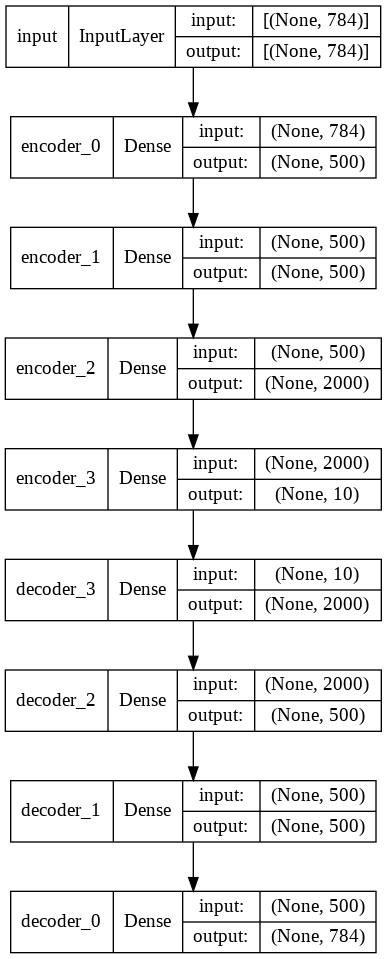

In [10]:
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
Image(filename='autoencoder.png') 

### Visualisation of the encoder

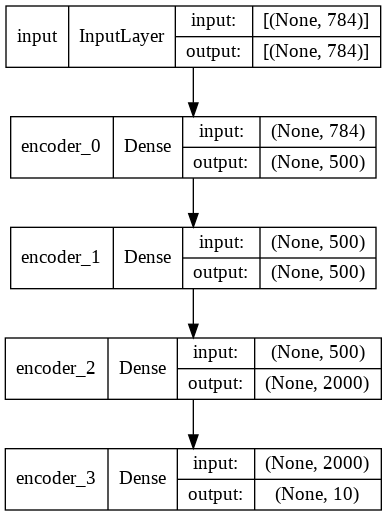

In [11]:
plot_model(encoder, to_file='encoder.png', show_shapes=True)
Image(filename='encoder.png') 

## Fit the encoder

In [12]:
%%time
autoencoder.compile(optimizer = pretrain_optimizer, loss = 'mse')
autoencoder.fit(x, x, batch_size = batch_size, epochs = 300)

Epoch 1/300
274/274 [==============================] - 5s 11ms/step - loss: 0.0645
Epoch 2/300
274/274 [==============================] - 3s 10ms/step - loss: 0.0445
Epoch 3/300
274/274 [==============================] - 3s 10ms/step - loss: 0.0328
Epoch 4/300
274/274 [==============================] - 3s 10ms/step - loss: 0.0276
Epoch 5/300
274/274 [==============================] - 3s 10ms/step - loss: 0.0245
Epoch 6/300
274/274 [==============================] - 3s 10ms/step - loss: 0.0227
Epoch 7/300
274/274 [==============================] - 3s 10ms/step - loss: 0.0215
Epoch 8/300
274/274 [==============================] - 3s 10ms/step - loss: 0.0205
Epoch 9/300
274/274 [==============================] - 3s 10ms/step - loss: 0.0197
Epoch 10/300
274/274 [==============================] - 3s 10ms/step - loss: 0.0191
Epoch 11/300
274/274 [==============================] - 3s 10ms/step - loss: 0.0186
Epoch 12/300
274/274 [==============================] - 3s 10ms/step - loss: 0.0181
E

### We save the weights from the encoder part

In [13]:
autoencoder.save_weights('/content/ae_weights.h5')

In [14]:
autoencoder.load_weights('/content/ae_weights.h5')

## Clustering layer

This clustering layer allows to assign to the encoder outputs (the images compressed in 10 features), a probability to be in each cluster. The weights of this clustering step are initialized with Kmeans once the dimensionality is reduced.

In [15]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape = (self.n_clusters, input_dim), initializer='glorot_uniform', name = 'clusters') 
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [16]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

### Visualisation of the final network 

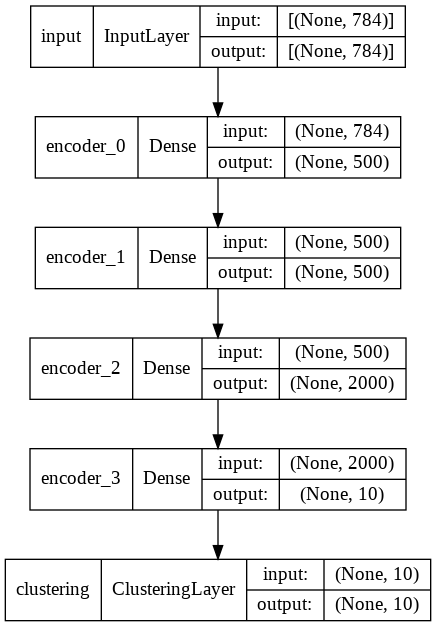

In [17]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png') 

In [18]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

# Initialisation of the centroïds via Kmeans

Now that the dimensionality of each image is reduced to 10, KMeans can more easily generate the centroids, which we will improve with the Kullback Leibler divergence.

In [19]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [20]:
y_pred_last = np.copy(y_pred)

In [21]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

# Kullback Leibler

Now we improve the clustering by defining a target distribution and minimizing the clustering distribution with the target distribution using the Kullback Leibler divergence.

In [22]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

The target distribution is calculated by squaring the encoded vectors and normalizing the frequency by cluster.

In [23]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training

The performance improvement process is done iteratively, the target distribution is updated after a number of iterations (here 140) and the model minimizes the divergence between the clustering clusters and the new target distribution.

In [24]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc1 = np.round(acc(y, y_pred), 5)
            print('Itération n° : ' + str(ite) + ', accuracy : ' + str(acc1) + ', loss : ' + str(loss))

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Tolerance threshold reached.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

Itération n° : 0, accuracy : 0.91006, loss : 0
Itération n° : 140, accuracy : 0.91734, loss : 0.04481035843491554
Itération n° : 280, accuracy : 0.9279, loss : 0.15627045929431915
Itération n° : 420, accuracy : 0.93491, loss : 0.20846548676490784
Itération n° : 560, accuracy : 0.93896, loss : 0.2182733416557312
Itération n° : 700, accuracy : 0.94229, loss : 0.21349124610424042
Itération n° : 840, accuracy : 0.94441, loss : 0.20881178975105286
Itération n° : 980, accuracy : 0.94613, loss : 0.20667779445648193
Itération n° : 1120, accuracy : 0.94739, loss : 0.19736118614673615
Itération n° : 1260, accuracy : 0.94839, loss : 0.19646883010864258
Itération n° : 1400, accuracy : 0.94916, loss : 0.1931241750717163
Itération n° : 1540, accuracy : 0.94959, loss : 0.1800418645143509
Itération n° : 1680, accuracy : 0.94986, loss : 0.17395684123039246
Itération n° : 1820, accuracy : 0.95051, loss : 0.1827106922864914
Itération n° : 1960, accuracy : 0.95036, loss : 0.1703634411096573
Itération n° :

The iteration procedure stopped after more than 7000 iterations, the difference between the last and the second last prediction being smaller than the tolerance threshold (0.001).

In [25]:
model.save_weights('/content/DEC_model_final.h5')

In [26]:
model.load_weights('/content/DEC_model_final.h5')

In [27]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc1 = np.round(acc(y, y_pred), 5)
    loss1 = np.round(loss, 5)
    print('Accuracy : ' + str(acc1) + ', loss : ' + str(loss))

Accuracy : 0.95287, loss : 0.10267943888902664


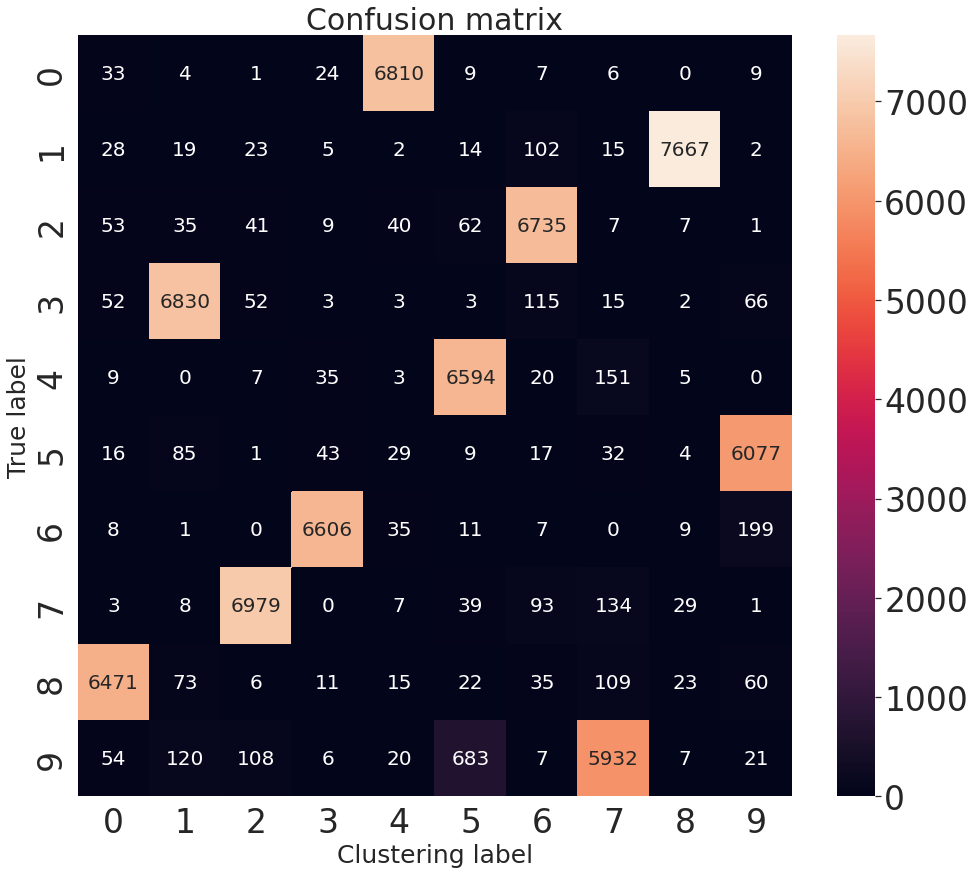

In [28]:
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

Each digit has a single cluster, except for 4 and 9 which are similar in shape and are distributed rather evenly between two clusters.

In [29]:
accuracy_kmeansnet = acc(y,y_pred)

In [30]:
print("Usual Kmeans Precision: " + str(round(accuracy_kmeans, 4)))
print("KmeansNet Precision: " + str(round(accuracy_kmeansnet, 4)))
print("Gain of Prediction : " + str(round(accuracy_kmeansnet - accuracy_kmeans,4)))

Usual Kmeans Precision: 0.5324
KmeansNet Precision: 0.9529
Gain of Prediction : 0.4205


The KMeansNet algorithm resulted in an accuracy improvement of 0.42, a significant gain.